In [1]:
import json
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [2]:
start = pd.to_datetime('2007-07-07')

In [3]:
stock = ['AMZN']

In [4]:
data = yf.download(stock, start=start, end=datetime.date.today())

[*********************100%***********************]  1 of 1 completed


In [5]:
min_max = preprocessing.MinMaxScaler()

In [6]:
data_scaled = pd.DataFrame(min_max.fit_transform(data), columns=data.columns)

In [7]:
data_scaled_close = data_scaled['Close']

In [8]:
data_scaled_close

0       0.010021
1       0.009536
2       0.009658
3       0.010215
4       0.010840
          ...   
3879    0.507245
3880    0.499832
3881    0.482951
3882    0.468017
3883    0.469154
Name: Close, Length: 3884, dtype: float64

In [9]:
np.array(data_scaled_close).reshape(-1, 1).shape

(3884, 1)

In [10]:
train_num = int(data_scaled.shape[0] * 0.7)

In [11]:
test = pd.Timestamp("2018-07-31 00:00:00", tz="America/New_York")

In [12]:
data['Close'][data.index > test]

Date
2018-08-01 00:00:00-04:00    89.858498
2018-08-02 00:00:00-04:00    91.716499
2018-08-03 00:00:00-04:00    91.164497
2018-08-06 00:00:00-04:00    92.387497
2018-08-07 00:00:00-04:00    93.124001
                               ...    
2022-12-01 00:00:00-05:00    95.500000
2022-12-02 00:00:00-05:00    94.129997
2022-12-05 00:00:00-05:00    91.010002
2022-12-06 00:00:00-05:00    88.250000
2022-12-07 00:00:00-05:00    88.459999
Name: Close, Length: 1097, dtype: float64

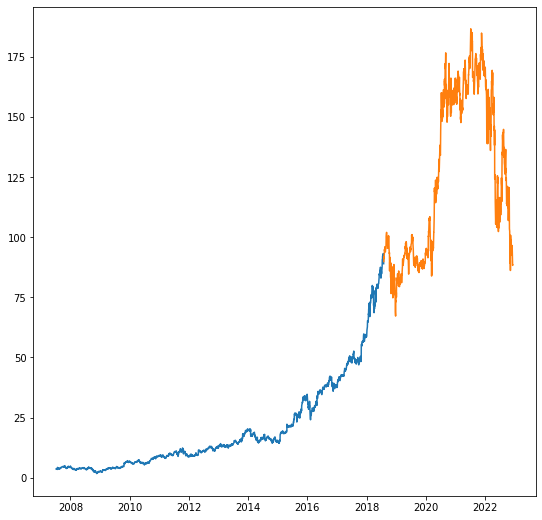

In [13]:
plt.figure(figsize=(9, 9))

plt.plot(data['Close'][data.index < test])
plt.plot(data['Close'][data.index > test])
plt.show()

In [14]:
data_train = np.array(data_scaled['Close'][data.index < test]).reshape(-1, 1)
data_test = np.array(data_scaled['Close'][data.index > test]).reshape(-1, 1)
#data_train = data_scaled['Close'][data.index < test]
#data_test = data_scaled['Close'][data.index > test]

In [15]:
data_train.shape[0]

2786

In [16]:
len(data_train)

2786

In [17]:
data_test.shape

(1097, 1)

In [18]:
def get_train(train_scaled, time_steps = 3):
    x_train = []
    y_train = []
    for i in range(time_steps, train_scaled.shape[0]):
        x_train.append(train_scaled[i - time_steps:i, 0])
        y_train.append(train_scaled[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train

In [19]:
x_train, y_train = get_train(data_train)

In [20]:
print("x.shape = ", x_train.shape, ", y.shape = ", y_train.shape)

x.shape =  (2783, 3, 1) , y.shape =  (2783,)


In [21]:
def get_test(test_scaled, time_steps = 3):
    x_test = []
    y_test = []
    for i in range(time_steps, test_scaled.shape[0]):
        x_test.append(test_scaled[i - time_steps:i])
        y_test.append(test_scaled[i, 0])
        
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_test, y_test

In [22]:
x_test, y_test = get_test(data_test)

In [23]:
print("xt.shape = ", x_test.shape, ", yt.shape = ", y_test.shape)

xt.shape =  (1094, 3, 1) , yt.shape =  (1094,)


In [24]:
def long_short_term_memory_model(alpha=0.2):
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(32, 5, activation='relu', strides=1, padding='causal', input_shape=[3, 1]))
    model.add(layers.Dropout(alpha))
    
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.Dropout(alpha))
    
    model.add(layers.LSTM(64))
    model.add(layers.Dense(1))

    return model

In [25]:
model = long_short_term_memory_model(alpha=0.2)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             192       
                                                                 
 dropout (Dropout)           (None, 3, 32)             0         
                                                                 
 lstm (LSTM)                 (None, 3, 64)             24832     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 58,113
Trainable params: 58,113
Non-traina

In [26]:
defined_metrics = tf.keras.metrics.MeanSquaredError() 
defined_loss = tf.keras.losses.MeanSquaredError()
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0005) 

model.compile(optimizer=opt_adam, loss=defined_loss, metrics=defined_metrics)

In [27]:
history = model.fit(x_train, y_train, epochs=40, batch_size=1024, validation_data=(x_test, y_test))

Epoch 1/40
3/3 [==============================] - 5s 380ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.4659 - val_mean_squared_error: 0.4659
Epoch 2/40
3/3 [==============================] - 0s 26ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.4367 - val_mean_squared_error: 0.4367
Epoch 3/40
3/3 [==============================] - 0s 25ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.4073 - val_mean_squared_error: 0.4073
Epoch 4/40
3/3 [==============================] - 0s 25ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.3769 - val_mean_squared_error: 0.3769
Epoch 5/40
3/3 [==============================] - 0s 26ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.3452 - val_mean_squared_error: 0.3452
Epoch 6/40
3/3 [==============================] - 0s 27ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.3126 - val_mean_squared_error: 0.3126
Epoch 7/40
3/3 [=============================

In [28]:
output = model.predict(x_test)

35/35 [==============================] - 1s 6ms/step


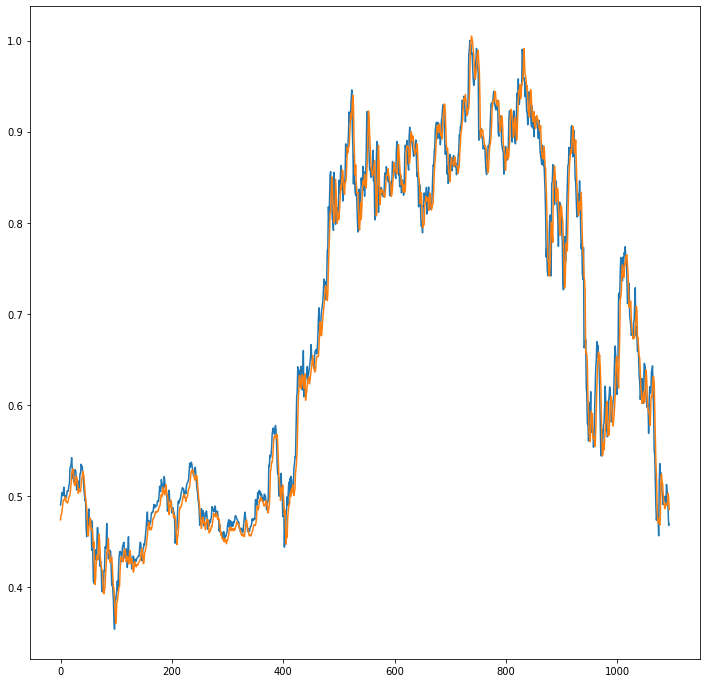

In [29]:
plt.figure(figsize=(12, 12))

plt.plot(y_test)
plt.plot(output)
plt.show()